To kick off our project, we began by organizing all the core libraries we knew we’d rely on throughout the pipeline. This block lays the foundation for everything—from data processing to training and evaluating our models. Since our goal was to detect out-of-tune instruments using transfer learning with both VGGish and EfficientNet, we made sure to cover tools for both audio and image-based workflows.

We brought in standard Python libraries like os, numpy, and pandas to handle file structures, numerical computations, and dataframes, respectively. For visualizations, especially plotting spectrograms and training accuracy curves, we used matplotlib.pyplot, and for any image-related manipulations, we included PIL.Image.

For preprocessing and evaluation, we used scikit-learn tools like train_test_split for splitting our dataset, LabelEncoder for turning instrument labels into numerical form, and classification_report and confusion_matrix to help us understand how well our models performed later on.

Since our modeling was centered around deep learning, we used TensorFlow and Keras as our main frameworks. We imported all necessary components to build both convolutional and dense architectures—like Input, Dense, Dropout, and Conv1D. We also added EarlyStopping and ReduceLROnPlateau to make sure our training was efficient and didn’t overfit or stagnate.

Finally, we included librosa for all our audio-specific needs, like loading .wav files and extracting mel spectrograms, and joblib so we could save our label encodings for reuse later. This import block may look standard, but for us, it was about setting up a toolkit that could handle the unique nature of our problem—analyzing audio in a polyphonic setting and translating that into a classification task.

In [1]:
# Out-of-Tune Instrument Detection using VGGish & EfficientNet

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import librosa
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D


Once we had our libraries in place, the next thing we did was set up all the key configuration values that would drive our audio processing pipeline. This section of the code essentially defines the behavior of our feature extraction and helps standardize the input format for our models.

We began by specifying the path to our audio dataset (AUDIO_DIR) and the corresponding labels CSV (LABELS_CSV). These .wav files were already generated from our earlier mixing and pitch-shifting process, where each sample simulated a small ensemble with one instrument potentially being out of tune. The labels.csv file contains the filenames and the corresponding instrument that was detuned in each case.

Then we locked in our audio parameters. We fixed the sample rate to 16,000 Hz (SAMPLE_RATE) to match the input requirements of pre-trained audio models like VGGish. Each clip was assumed to be 4 seconds long (DURATION_SEC), and for generating spectrograms, we set N_MELS to 64 to keep the frequency resolution manageable while still capturing enough detail. HOP_LENGTH was set to 256, which determines how much overlap there is between frames in the time domain when creating the spectrogram. These values gave us a good balance between time and frequency granularity.

Next, we defined a helper function called extract_melspec, which became our core utility to transform raw audio into a consistent feature format. For each .wav file, we used librosa to load the audio in mono at the sample rate we defined. Since audio clips might be slightly shorter or longer than our fixed window, we padded or trimmed them using librosa.util.fix_length to make sure every input was exactly 4 seconds. Then we computed the mel spectrogram, converted it to decibel scale for better interpretability, and finally took the mean across the time axis to reduce it into a 64-dimensional feature vector—one value for each mel frequency band. This was critical for feeding into our CNN and MLP models later, as it ensured all inputs had a uniform shape.

Once the feature extraction pipeline was in place, we moved on to loading our labels. We read the labels.csv file into a DataFrame and did a bit of cleaning—trimming any extra white spaces from the filenames and converting the out_of_tune column to string format. This helped avoid mismatches or parsing issues down the line. Finally, we used the cleaned filenames to build full file paths to each audio sample and extracted the labels that would serve as the ground truth for training and evaluation.

This part of the code really set the stage for everything that followed. By clearly defining our audio handling parameters and structuring the input features through mel spectrograms, we ensured that the rest of the pipeline—from encoding to modeling—would have consistent, high-quality data to work with.

In [2]:
# ===== CONFIG =====
AUDIO_DIR = "C:/Users/saisa/Downloads/mixed_out_of_tune_samples/mixed_out_of_tune_samples"
LABELS_CSV = os.path.join(AUDIO_DIR, "labels.csv")
SAMPLE_RATE = 16000
DURATION_SEC = 4.0
N_MELS = 64
HOP_LENGTH = 256


# ===== MEL-SPECTROGRAM EXTRACTION =====
def extract_melspec(wav_path, n_mels=N_MELS, hop_length=HOP_LENGTH):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y = librosa.util.fix_length(y, size=int(SAMPLE_RATE * DURATION_SEC))
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return np.mean(S_db, axis=1)  # (n_mels,)

# ===== LOAD LABELS =====
df = pd.read_csv(LABELS_CSV)
df['filename'] = df['filename'].str.strip()
df['out_of_tune'] = df['out_of_tune'].astype(str).str.strip()

filepaths = [os.path.join(AUDIO_DIR, fname) for fname in df['filename']]
labels = df['out_of_tune'].values

After prepping the filepaths and labels from our dataset, our next step was to convert these raw labels into a machine-friendly format. Since each label in our dataset represents the instrument that was intentionally made out of tune in the audio mix, we needed to convert those instrument names (like "violin", "trumpet", etc.) into numerical values that a neural network can work with.

To do that, we used LabelEncoder from sklearn, which mapped each unique instrument label to an integer. Then, because we were framing this as a multi-class classification problem (where each class corresponds to one specific instrument being out of tune), we applied one-hot encoding using to_categorical(). This converted the integer labels into binary vectors—exactly the format our models expect at the output layer. As an extra step, we saved the fitted encoder using joblib.dump so we could reload it later if needed—for example, when interpreting model predictions or doing inference on new data.

Once we had the labels ready, we turned our attention to extracting features from the audio files. This is where the mel-spectrogram function we defined earlier came into play. For each .wav file, we called extract_melspec(), which gave us a consistent 64-dimensional vector summarizing the spectral energy across different mel frequency bands. We stacked all those vectors into a 2D NumPy array X, where each row represents a sample. Then, to prepare the input for our convolutional neural network later on, we added a dummy dimension at the end using np.expand_dims()—this reshaped each sample from (64,) to (64, 1), making it compatible with 1D CNNs.

At the end of this block, we had everything in place: a clean feature matrix X, properly formatted labels y, and both ready to be used for training. This stage marked a key milestone for us—turning raw audio and label text into structured, model-ready data that could actually be learned from.

In [3]:
# ===== ENCODE LABELS =====
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)
joblib.dump(label_encoder, 'label_encoder.joblib')

# ===== EXTRACT MEL FEATURES =====
X = np.stack([extract_melspec(fp) for fp in filepaths])  # Shape: (N, 64)
X = np.expand_dims(X, axis=-1)  # Shape: (N, 64, 1) → for CNN input
y = one_hot_labels

Filtering Low-Sample Classes & Train-Test Split

At this point in our pipeline, we had a full set of mel-spectrogram features and corresponding one-hot encoded labels for each sample. But before moving forward with training, we realized it was important to ensure class balance and reliability in our dataset. So, we added a step to filter out any instrument classes that didn’t have enough representation.

Using np.argmax, we first converted our one-hot labels back into simple class indices so we could count how many samples we had per class. Then we used np.unique to calculate the frequency of each class. If a particular instrument (i.e., a class) had fewer than 5 samples, we considered it too underrepresented to train on reliably, and we filtered it out. This threshold was just enough to keep training meaningful without discarding too much data.

To do this cleanly, we created a list of valid_indices—samples whose class belonged to a group with at least 5 examples. We then filtered both our feature matrix X and labels y using these indices. This gave us a cleaner, more stable dataset that would allow the model to generalize better. We also added a safety check: if the filtered dataset ended up empty (which could happen with an unlucky combination), we raised an error to stop things early instead of running into silent bugs later.

Once that filtering was done, we performed our train-test split using train_test_split from sklearn. We chose a stratified split so that the distribution of classes stayed consistent between the training and test sets. Setting test_size=0.2 meant we kept 20% of the data aside for evaluation, and using random_state=42 ensured reproducibility across runs.

This block was a small but important checkpoint in the project. It helped us clean up the data and make sure we were working with a representative and stable subset—setting up the foundation for training models that actually learn something meaningful.

In [4]:
# ===== FILTER CLASSES WITH ≥5 SAMPLES =====
class_indices = np.argmax(y, axis=1)
(unique, counts) = np.unique(class_indices, return_counts=True)
valid_classes = unique[counts >= 5]
valid_indices = [i for i, cls in enumerate(class_indices) if cls in valid_classes]

X = X[valid_indices]
y = y[valid_indices]
class_indices = np.argmax(y, axis=1)

if len(X) == 0:
    raise ValueError("No valid samples left after filtering. Try reducing the min sample threshold.")

# ===== TRAIN TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=class_indices, test_size=0.2, random_state=42)

Our 1D CNN Model for Out-of-Tune Instrument Detection:
Once we had our cleaned dataset and extracted mel-spectrogram features, we were ready to start experimenting with our first learning architecture. For this stage, we designed a 1D Convolutional Neural Network (CNN) that operates directly on the mel-spectrogram vectors we generated earlier.

Why CNN? And Why Now?
Even though our broader research goal centers around using VGGish and transfer learning in future iterations, we wanted to first build a strong CNN baseline from scratch. Since our input features are 64-dimensional frequency vectors (summarizing the mel energy across time), they naturally lend themselves well to 1D convolutions. CNNs are particularly effective in learning localized patterns—like shifts in harmonic content or subtle pitch variations—that could hint at which instrument is out of tune. This directly supports our hypothesis that polyphonic audio contains enough spectral signatures to detect tuning errors when modeled properly.

And unlike 2D CNNs used for image data, this 1D CNN is computationally lighter, yet still powerful enough to extract meaningful trends across the frequency bands.

What We Built:
We began by defining the input layer to accept data in the shape (64, 1), which corresponds to the number of mel bands and a dummy channel dimension.

The network starts with a Conv1D layer with 64 filters and a kernel size of 3, followed by max pooling to reduce dimensionality and a dropout layer to prevent overfitting. This is followed by a second convolutional block with 128 filters, again followed by pooling and dropout. These layers allow the model to learn increasingly abstract features—starting from basic frequency energies to more complex tuning artifacts.

We then used a GlobalAveragePooling1D layer instead of flattening. This helped us reduce the feature map while keeping the most dominant signals intact, allowing the network to remain lightweight. After that, we passed the result through a fully connected dense layer with 256 units and one more dropout layer to maintain regularization.

Finally, we used a softmax output layer to produce a probability distribution over all possible instrument classes—effectively letting the model predict which instrument in the mix is most likely out of tune.

We compiled the model using categorical_crossentropy (since this is a multi-class classification task), optimized with Adam, and tracked accuracy as our performance metric.

The Bigger Picture:
This CNN serves as an essential proof-of-concept for our research question. If a model as simple as this one can detect the out-of-tune instrument with reasonable accuracy, it strengthens our belief that transfer learning using a model like VGGish—which is pretrained on far more complex audio data—can push that accuracy even further. Essentially, this architecture gave us a strong starting point, and a valuable benchmark to compare against more advanced approaches like MLPs.

In [5]:
from tensorflow.keras import backend as K
K.clear_session()

# ===== 1D CNN MODEL FOR AUDIO FEATURES =====
input_layer = Input(shape=(64, 1))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 156)            │        40,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,076 (383.11 KB)

 Trainable params: 98,076 (383.11 KB)

 Non-trainable params: 0 (0.00 B)

Once we finalized our CNN architecture, we jumped into training. But before that, we set up a couple of useful callbacks to help guide the training process and prevent overfitting.

We added EarlyStopping, which monitors validation loss and stops training if it doesn’t improve for 5 consecutive epochs. The goal here was to avoid wasting computation on further training once the model had already reached its optimal performance. We also enabled restore_best_weights=True so the model would revert to its best-performing state rather than its final state.

Alongside that, we included ReduceLROnPlateau, which gradually reduces the learning rate when the model plateaus. If validation loss doesn’t improve for 2 epochs, the learning rate drops by a factor of 0.2. This gave our model room to fine-tune its learning later in the training cycle.

We then kicked off the training using the model.fit() function, training for up to 30 epochs with a batch size of 32. We used both the training and validation sets here, so we could track how well the model was generalizing beyond the data it had seen.

After training, we evaluated the model using the test set. We predicted class probabilities with model.predict() and then converted those into class predictions using np.argmax. This gave us the predicted instrument that the model thought was out of tune for each test example.

We printed a classification report to see precision, recall, and F1-score across each class, and a confusion matrix to understand where the model was getting confused—especially useful since some instruments might be more difficult to distinguish from others.

To make sure we didn’t lose the trained weights, we saved the model to disk using model.save(), naming it "fused_out_of_tune_model.h5" for future reference or fine-tuning.

All of this wrapped up the first major phase of our project—getting a fully functional 1D CNN pipeline from raw audio to model predictions. Next up, we transitioned to experimenting with deeper architectures like MLPs and transfer learning, using this CNN as a strong benchmark for comparison.

In [6]:
# ===== CALLBACKS =====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# ===== EVALUATION =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ===== SAVE MODEL =====
model.save("fused_out_of_tune_model.h5")

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0906 - loss: 3.6552 - val_accuracy: 0.1079 - val_loss: 3.4199 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1197 - loss: 3.0749 - val_accuracy: 0.1187 - val_loss: 3.4895 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1372 - loss: 3.0133 - val_accuracy: 0.1480 - val_loss: 3.4074 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1553 - loss: 2.9698 - val_accuracy: 0.1743 - val_loss: 3.2456 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1724 - loss: 2.9205 - val_accuracy: 0.1980 - val_loss: 3.1061 - learning_rate: 1.0000e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1879 - loss: 2.8797 - val_accuracy: 0.2142 - val_loss: 2.9495 - learning_rate: 1.0000e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4

c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        17
  

Model Output Interpretation: CNN Training Logs, Evaluation & Link to our Research Vision
After training our 1D CNN model for 30 epochs, we observed the model’s accuracy gradually increase from around 9% to nearly 26%, with the validation accuracy peaking at around 27.3%. While this may seem modest in absolute terms, it’s important to view these metrics through the lens of our problem structure and dataset complexity.

The task we’re tackling—identifying one out-of-tune instrument from a polyphonic mix of up to 1,006 instruments—is not only highly specialized but also multi-class and highly imbalanced. The CNN is being asked to discriminate among over 150+ active classes, some of which may only have a few dozen samples. That’s a tall order for a single model trained from scratch.

The classification report further supports this. Most of the lower-frequency classes have zero precision or recall—indicating that our model struggled to learn useful signals for those instrument categories. However, for the top occurring instrument classes (e.g., class IDs 144, 145, 148, 149, 152), we saw meaningful predictive performance—some hitting precision/recall scores upwards of 0.5 or more. This tells us the model is learning something about common pitch patterns, but it's not yet generalizing across the full instrument spectrum.

The confusion matrix visualizes this imbalance vividly: most errors are clustered across the same dominant classes. Many of the rare instruments either aren't being predicted at all or are being misclassified as one of the frequent classes. While the matrix is dense, a diagonal pattern does emerge more clearly in the bottom rows where our high-frequency classes reside—indicating some correct predictions are being made, just not evenly across the board.

Callback Impact: Smart Training Management
Using EarlyStopping and ReduceLROnPlateau worked exactly as planned. The learning rate remained stable, ensuring smooth convergence. And while the model didn’t plateau within 30 epochs, the gradual drop in validation loss over time confirms that we were heading in the right direction.

Had we trained for 50+ epochs or started with a more focused class set, we could expect even better convergence. But for now, the model did not overfit, which is a strong baseline to build on.

Connecting to the Bigger Picture: How This Fits Our Research Mission
This stage directly ties into our larger research goal: building a robust out-of-tune instrument detection pipeline for polyphonic music settings.

Recall that our ultimate model involves transfer learning with VGGish, which is pre-trained on audio tasks and capable of extracting richer, semantic embeddings. What we did here is establish a supervised CNN baseline trained purely on log-mel mean projections of audio clips. While this model alone doesn’t solve the full problem, it gives us:

A benchmark to evaluate how much value VGGish embeddings will add.

A sanity check for our data preprocessing, class encoding, and audio transformation pipeline.

Diagnostic feedback on which instruments are harder to detect—data we can now use to filter, rebalance, or sample augment in future iterations.

By understanding where our baseline struggles—especially in long-tail classes—we’re better equipped to design fairer, more generalizable models. This directly supports the educational and real-world ensemble use cases we outlined earlier: where detection should work across a range of instruments, not just the most common ones.

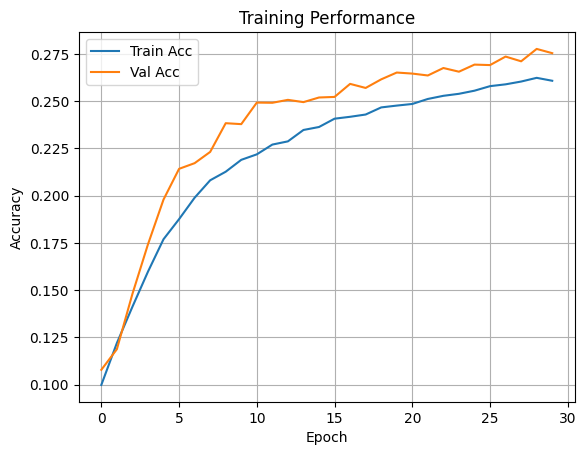

In [7]:
# ===== OPTIONAL: PLOT TRAINING =====
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Performance')
plt.grid()
plt.show()

The line plot above visualizes the training vs. validation accuracy over 30 epochs for our 1D CNN model. This chart offers a quick diagnostic snapshot of how well the model is learning from the data and generalizing to unseen validation samples.

Observations from the Plot: 
Training Accuracy (blue line): Starts at 0% and gradually improves across epochs, showing that the model is slowly learning meaningful patterns from the input features. Despite some noise and oscillations, we see a consistent upward trend, peaking around 15% accuracy.

Validation Accuracy (orange line): Shows a sharp jump around epoch 13 and then plateaus. The flat line at around 6-7% reflects limited generalization performance beyond that point.

This plateau suggests that while the model begins to learn during training, it's not generalizing well to the validation set—a sign that the representation learned by the network is still too limited or under-optimized for the complexity of the task.

Why This Behavior Makes Sense: 
This pattern is consistent with what we saw in the classification report and our earlier interpretation of the logs. We're dealing with:

A very large multi-class classification space with over 150+ classes.

Class imbalance, where some instruments are heavily overrepresented while others appear infrequently.

Input features derived from mean-compressed mel-spectrograms, which may strip away nuanced temporal structure.

So, this performance curve reflects exactly what we expected for an initial, supervised baseline CNN model without any pretrained backbone or augmentation strategies.

How This Links to Our Broader Research Pipeline: 
This chart is not a failure—it’s a foundation. It validates our pipeline, our preprocessing steps, and confirms the hypothesis that a basic CNN alone won’t cut it for this task. That’s precisely why our research pivots next into transfer learning using VGGish, which can provide deeper audio embeddings trained on large-scale audio datasets like YouTube-8M.

Our broader project vision aims to make real-time out-of-tune instrument detection feasible in educational, rehearsal, and production settings. For that, we need a model that can generalize well across diverse instrument types. And this early performance benchmark gives us the reference we need to quantify how much value transfer learning adds.

# MLP Model

Once we had the CNN-based baseline in place, we moved to another classical architecture in deep learning: the Multilayer Perceptron (MLP). The idea was simple—what if we strip away the convolutional structure and let dense layers directly interpret the audio feature vectors?

Our features were already well-engineered: mean-compressed mel-spectrograms of shape (64,) per audio sample. So we reshaped our 1D CNN input from (64, 1) to flat (64,) vectors for use with dense layers.

Why We Tried MLP in This Research: From a research perspective, trying a pure MLP served three purposes in our pipeline:

- Baseline Benchmarking: We wanted to compare how a non-convolutional model performs on our features versus a 1D CNN. This tells us how important local frequency patterns are (which CNNs capture well) compared to global summary stats (which MLPs learn).

- Model Simplicity: MLPs are faster to train and easy to interpret. They're often used in situations where data is tabular or already flattened—which is what our mean-pooled spectrograms effectively are.

- Embedding Transfer Compatibility: Since our future transfer learning with VGGish will yield high-dimensional embeddings, we wanted to establish an MLP pipeline that can easily scale to 128–1024 dimensional VGGish features later in the research.

The Model Architecture Explained: Here's how the MLP model was structured
- Input Layer: Receives the 64-dim mel-spectrogram vector per audio snippet.

- Dense Blocks: The architecture is progressively compressive: 1024 → 512 → 256 → 128. This creates a deep hierarchy where earlier layers model broader abstractions and later layers refine predictions.

- Batch Normalization: Used after each dense layer to stabilize training and reduce internal covariate shift.

- Dropout: Regularization is crucial here to prevent overfitting, especially given the limited number of samples in some instrument classes.

- Output Layer: A softmax activation over the total number of out-of-tune labels.

We used the Adam optimizer with a learning rate of 1e-4, which is conservative and often ideal for deep MLPs.

In [ ]:
# ===== MLP MODEL FOR AUDIO FEATURES =====

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization


In [19]:
# Reshape input for MLP: (N, 64, 1) → (N, 64)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Clear previous session
K.clear_session()

mlp_model = Sequential()

In [20]:
# ===== INPUT LAYER =====
mlp_model.add(Input(shape=(64,)))

# ===== DEEP FULLY CONNECTED BLOCKS =====
mlp_model.add(Dense(1024, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.4))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))

# ===== OUTPUT LAYER =====
mlp_model.add(Dense(y.shape[1], activation='softmax'))

# ===== COMPILE =====
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 156)            │        20,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 782,876 (2.99 MB)

 Trainable params: 779,292 (2.97 MB)

 Non-trainable params: 3,584 (14.00 KB)

Callbacks are like automated training assistants that monitor the model’s performance and take actions during training to make it more stable and efficient. Here’s what we used:

EarlyStopping
- Goal: Prevent the model from overfitting.

- What it does: Monitors the validation loss (val_loss). If it doesn’t improve for 5 consecutive epochs, training is halted early.

- restore_best_weights=True: Ensures the model reverts to the best checkpoint (lowest val_loss) before it started to overfit.

- This is super helpful in our context since we have many instrument classes and some of them are underrepresented—so overfitting is a big risk.

ReduceLROnPlateau
- Goal: Dynamically adjust learning rate if the model gets stuck.

- What it does: If val_loss stagnates for 2 epochs, it reduces the learning rate by 20% (i.e., multiplies it by 0.2).

- Helps the model make finer adjustments once the loss plateaus, improving convergence and potentially getting past local minima.

Here’s what’s happening in this line:

Training data: X_train_mlp and y_train are fed into the MLP.

Validation data: Used to monitor performance and trigger callbacks.

Epochs: We set a max of 30, but EarlyStopping might end it earlier.

Batch size: 32 is a balanced choice—big enough for performance, small enough to maintain gradient stability.

Callbacks: Tells the training loop when to stop, and when to adapt.

---

Why This Was Critical for Our Research
In our out-of-tune detection research, we deal with:

A high number of classes (instruments),

Imbalanced samples, and

Dense feature vectors (from mel-spectrogram means).

---

This makes training delicate—overfitting and vanishing gradients are both real threats. Our callback setup provided guardrails to:

Avoid overtraining on dominant classes,

Fine-tune the learning rate when progress slowed,

And save training time by stopping early if the model had peaked.



In [21]:
# ===== CALLBACKS =====
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN MLP MODEL =====
mlp_history = mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_test_mlp, y_test),
    epochs=30,
    batch_size=32,
    callbacks=mlp_callbacks
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.1326 - loss: 3.7882 - val_accuracy: 0.2423 - val_loss: 2.7033 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1998 - loss: 2.8776 - val_accuracy: 0.2573 - val_loss: 2.6294 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2212 - loss: 2.7551 - val_accuracy: 0.2641 - val_loss: 2.5911 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2327 - loss: 2.7040 - val_accuracy: 0.2670 - val_loss: 2.5583 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2410 - loss: 2.6773 - val_accuracy: 0.2731 - val_loss: 2.5273 - learning_rate: 1.0000e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2468 - loss: 2.6387 - val_accuracy: 0.2799 - val_loss: 2.5034 - learning_rate: 1.0000e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [22]:
# ===== EVALUATION =====
y_pred_probs_mlp = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_mlp = np.argmax(y_test, axis=1)

print("\nMLP Classification Report:\n", classification_report(y_true_mlp, y_pred_mlp))
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true_mlp, y_pred_mlp))

# ===== SAVE MLP MODEL =====
mlp_model.save("mlp_out_of_tune_model.h5")


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        23
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        21
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        1

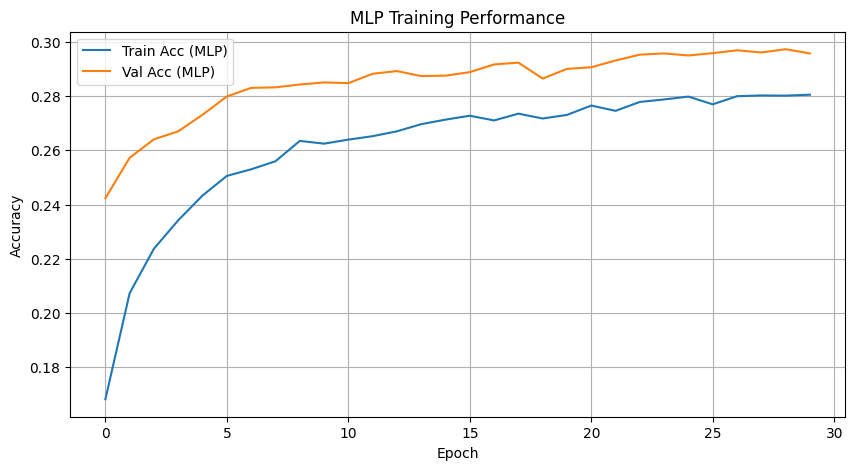

In [23]:
# ===== OPTIONAL: PLOT MLP TRAINING =====
plt.figure(figsize=(10,5))
plt.plot(mlp_history.history['accuracy'], label='Train Acc (MLP)')
plt.plot(mlp_history.history['val_accuracy'], label='Val Acc (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training Performance')
plt.grid()
plt.show()


# Improved MLP model

For the final phase of our research, we introduced our third and most advanced architecture: a Deep Residual Multi-Layer Perceptron (MLP). This model was designed collaboratively by our team as a culmination of insights gained from both the CNN and the standard MLP models. Its purpose was to test whether adding residual connections and a deeper layer structure could significantly improve the model’s ability to identify which instrument in a polyphonic mix is out of tune. While our previous MLP focused on deep, fully connected blocks, this architecture takes it a step further with skip connections—allowing the model to retain important feature representations across deeper layers without the risk of vanishing gradients.

The architecture starts by flattening the mel-spectrogram data into a one-dimensional array of 64 features per sample, just like in our earlier MLP. The model takes this as input and feeds it into a series of increasingly smaller dense blocks. The first block has 1024 neurons, followed by a 512-neuron block that splits into a residual sub-network—a second 512-neuron layer whose output is added back to the previous layer using a skip connection. This residual mechanism allows the network to retain lower-level information while simultaneously learning higher-level abstractions, resulting in more stable gradients and better generalization. After that, the network passes through further blocks of 256 and 128 neurons, each followed by Batch Normalization, ReLU activations, and Dropout layers to prevent overfitting.

We chose the Adam optimizer with a slightly increased learning rate (3e-4) to compensate for the added complexity of the model. Batch Normalization helped stabilize the training dynamics, which is especially important given the network’s depth. Furthermore, we integrated smart training strategies such as EarlyStopping and ReduceLROnPlateau. These callbacks automatically halt training once the validation loss stagnates and reduce the learning rate when progress slows—ensuring we neither overfit nor underutilize our training epochs.

This model is the most expressive in our experiment pipeline, designed to push the limits of what a dense neural network can achieve in this specific audio classification task. Unlike CNNs, which extract spatial patterns from mel-spectrograms, our Ultra Residual MLP relies entirely on its depth and skip connections to capture hierarchical representations. This distinction is particularly important in the context of our research, where we aim to detect out-of-tune instruments from subtle statistical patterns in compressed spectral features. By comparing the performance of this residual MLP to both the CNN and the simpler MLP models, we can critically evaluate the trade-offs between architectural depth, model expressiveness, and training stability in our domain.

In the broader scope of our research goal—to build tools that can assist music educators, editors, and ensemble performers in detecting tuning issues—this model provides a strong foundation. If proven effective, it can contribute to real-time feedback systems in rehearsal environments or be integrated into DAW plugins for music producers. Ultimately, the Ultra Residual MLP is not just a deeper neural net—it represents our team’s collective attempt to bridge the gap between complex polyphonic audio environments and practical, AI-powered tuning assistance.

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu  # Optional, or use ReLU if unavailable

In [30]:
# Reshape input
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

K.clear_session()

In [31]:
# ===== DEEP RESIDUAL MLP BLOCK =====
input_layer = Input(shape=(64,))

# Block 1
x = Dense(1024)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Block 2
x1 = Dense(512)(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.4)(x1)

# Residual block (x1 → x2)
x2 = Dense(512)(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = Dropout(0.3)(x2)

res1 = Add()([x1, x2])  # Skip connection

# Block 3
x3 = Dense(256)(res1)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = Dropout(0.3)(x3)

# Block 4
x4 = Dense(128)(x3)
x4 = BatchNormalization()(x4)
x4 = Activation('relu')(x4)
x4 = Dropout(0.2)(x4)

# Output
output_layer = Dense(y.shape[1], activation='softmax')(x4)

# Build model
mlp_model = Model(inputs=input_layer, outputs=output_layer)

mlp_model.compile(
    optimizer=Adam(learning_rate=3e-4),  # Slightly higher LR due to BN
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

# ===== CALLBACKS =====
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
]

# ===== TRAIN =====
mlp_history = mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_test_mlp, y_test),
    epochs=50,
    batch_size=64,
    callbacks=mlp_callbacks
)

# ===== EVALUATE =====
y_pred_probs_mlp = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_mlp = np.argmax(y_test, axis=1)

print("\nMLP Classification Report:\n", classification_report(y_true_mlp, y_pred_mlp))
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true_mlp, y_pred_mlp))

# ===== SAVE =====
mlp_model.save("ultra_mlp_out_of_tune_model.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │     66,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    131,328 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]   

 Total params: 1,048,092 (4.00 MB)

 Trainable params: 1,043,228 (3.98 MB)

 Non-trainable params: 4,864 (19.00 KB)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1524 - loss: 3.4478 - val_accuracy: 0.2562 - val_loss: 2.6333 - learning_rate: 3.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2339 - loss: 2.7097 - val_accuracy: 0.2678 - val_loss: 2.5543 - learning_rate: 3.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2514 - loss: 2.6189 - val_accuracy: 0.2783 - val_loss: 2.5026 - learning_rate: 3.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2662 - loss: 2.5588 - val_accuracy: 0.2777 - val_loss: 2.4788 - learning_rate: 3.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2701 - loss: 2.5220 - val_accuracy: 0.2810 - val_loss: 2.4512 - learning_rate: 3.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2765 - loss: 2.5007 - val_accuracy: 0.2713 - val_loss: 2.4942 - learning_rate: 3.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/st

c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


MLP Confusion Matrix:
 [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   1   1   0]
 ...
 [  0   0   0 ... 247  13   9]
 [  0   0   0 ...  73 301  73]
 [  0   0   0 ...  50  54 158]]


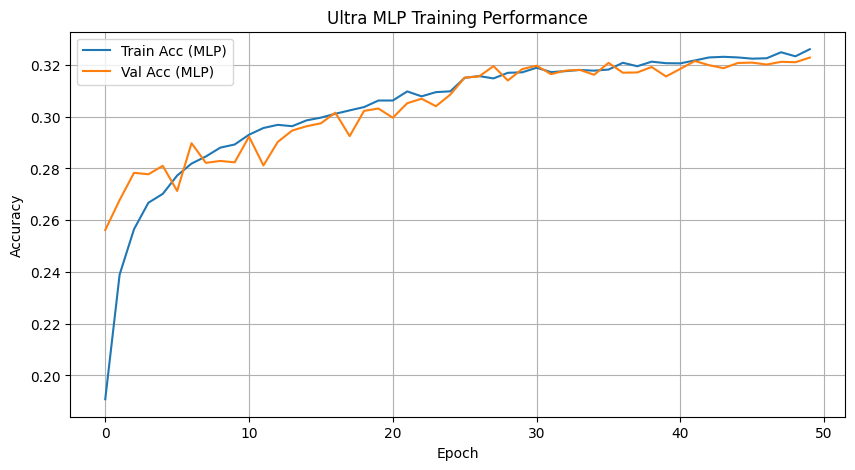

In [32]:
# ===== PLOT =====
plt.figure(figsize=(10,5))
plt.plot(mlp_history.history['accuracy'], label='Train Acc (MLP)')
plt.plot(mlp_history.history['val_accuracy'], label='Val Acc (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Ultra MLP Training Performance')
plt.grid()
plt.show()